Running Parallel Tempering MCMC on multimodal target...


100%|██████████| 10000/10000 [00:01<00:00, 7346.61it/s]



Diagnostics:
Temperatures: [0.01       0.01930698 0.03727594 0.07196857 0.13894955 0.26826958
 0.51794747 1.        ]
Within-chain acceptance rates: [0.9363 0.9095 0.8771 0.8343 0.7704 0.6816 0.5757 0.419 ]
Swap acceptance rates: [0.73684211 0.66666667 0.65436242 0.72318339 0.73591549 0.70895522
 0.69014085]
Mean swap rate: 0.702


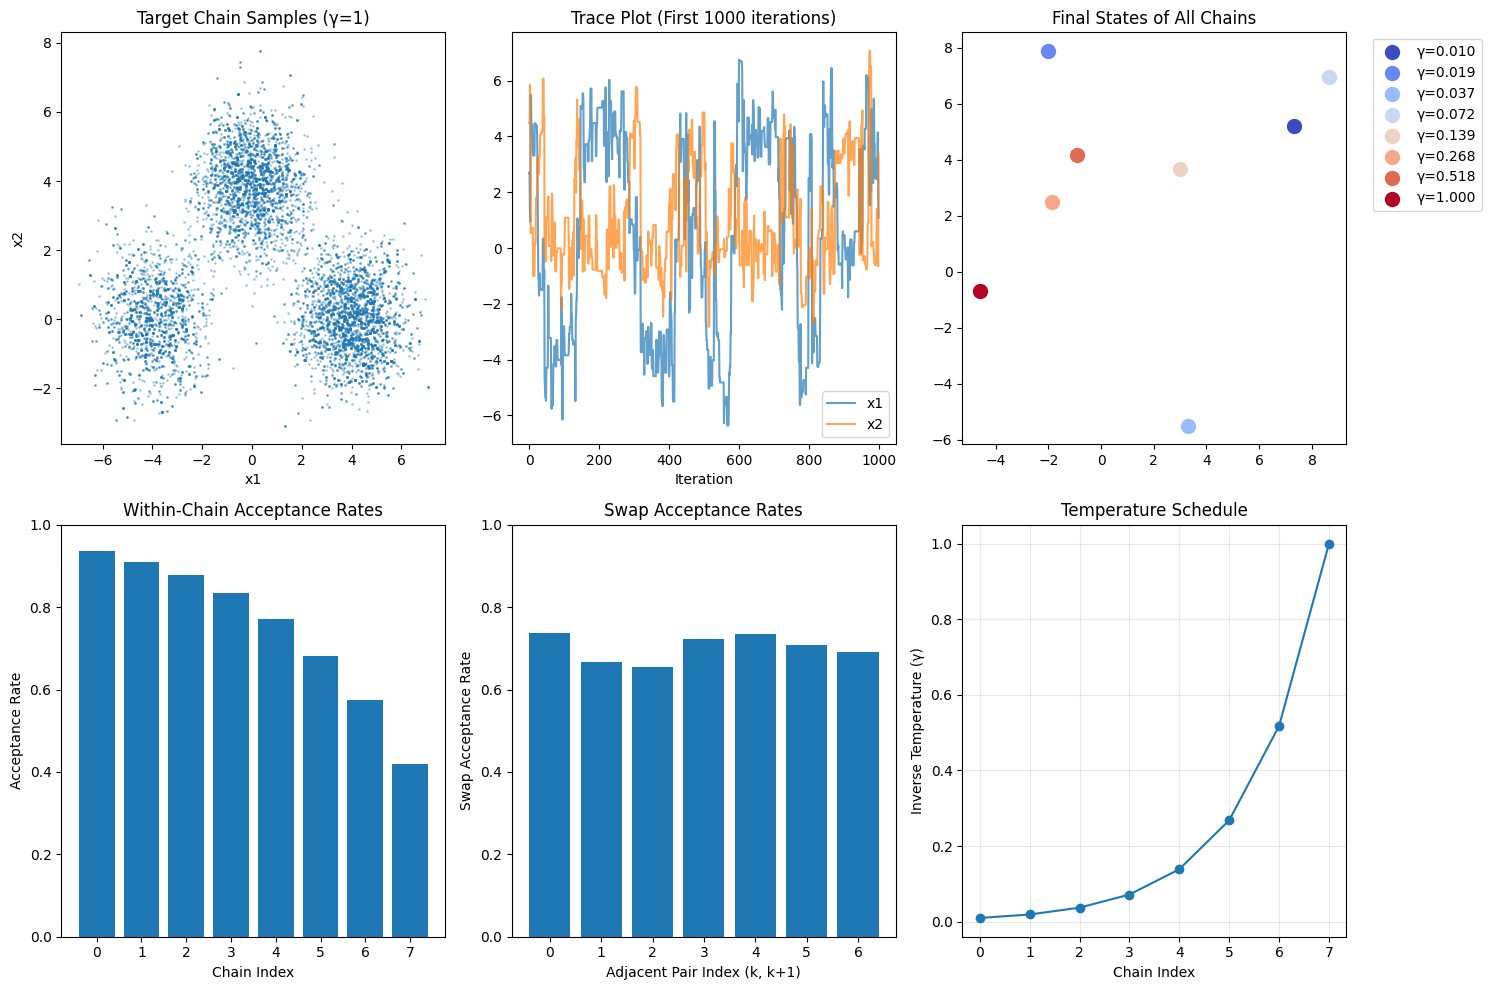

In [ ]:
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


class ParallelTempering:
    """
    Parallel Tempering MCMC with linear topology (adjacent chain swaps only).
    """

    def __init__(
        self,
        log_target: Callable[[np.ndarray], float],
        proposal: Callable[[np.ndarray, float], np.ndarray],
        log_proposal_ratio: Callable[[np.ndarray, np.ndarray], float],
        n_chains: int = 10,
        temperatures: Optional[np.ndarray] = None,
        swap_frequency: int = 1,
    ):
        """
        Initialize Parallel Tempering sampler.

        Args:
            log_target: Function computing log π(x)
            proposal: Function q(x_current, scale) returning proposed state
            log_proposal_ratio: Function computing log[q(x|y)/q(y|x)]
            n_chains: Number of parallel chains
            temperatures: Inverse temperatures γ. If None, uses geometric spacing
            swap_frequency: Attempt swaps every this many iterations
        """
        self.log_target = log_target
        self.proposal = proposal
        self.log_proposal_ratio = log_proposal_ratio
        self.n_chains = n_chains
        self.swap_frequency = swap_frequency

        # Set up inverse temperatures (γ values)
        if temperatures is None:
            # Geometric spacing from near 0 to 1
            self.temperatures = np.geomspace(0.01, 1.0, n_chains)
        else:
            self.temperatures = np.sort(temperatures)  # Ensure ascending order
            assert len(self.temperatures) == n_chains
            assert self.temperatures[-1] == 1.0  # Last chain targets π

        # Storage for chain states
        self.chains = None
        self.log_probs = None

        # Statistics tracking
        self.within_chain_accepts = np.zeros(n_chains)
        self.within_chain_attempts = np.zeros(n_chains)
        self.swap_accepts = np.zeros(n_chains - 1)  # Between adjacent pairs
        self.swap_attempts = np.zeros(n_chains - 1)

    def initialize_chains(self, init_func: Callable[[int], np.ndarray], dim: int):
        """
        Initialize all chains.

        Args:
            init_func: Function that takes chain index and returns initial state
            dim: Dimension of the state space
        """
        self.chains = np.zeros((self.n_chains, dim))
        self.log_probs = np.zeros(self.n_chains)

        for n in range(self.n_chains):
            self.chains[n] = init_func(n)
            self.log_probs[n] = self.log_target(self.chains[n])

    def within_chain_update(self, chain_idx: int, scale: float = 1.0):
        """
        Perform Metropolis-Hastings update for a single chain.

        Args:
            chain_idx: Index of chain to update
            scale: Proposal scale parameter
        """
        # Current state
        x_current = self.chains[chain_idx]
        log_p_current = self.log_probs[chain_idx]
        gamma = self.temperatures[chain_idx]

        # Propose new state
        x_proposed = self.proposal(x_current, scale)
        log_p_proposed = self.log_target(x_proposed)

        # Compute acceptance probability
        log_alpha = gamma * (log_p_proposed - log_p_current)
        log_alpha += self.log_proposal_ratio(x_current, x_proposed)

        # Accept or reject
        self.within_chain_attempts[chain_idx] += 1
        if np.log(np.random.random()) < log_alpha:
            self.chains[chain_idx] = x_proposed
            self.log_probs[chain_idx] = log_p_proposed
            self.within_chain_accepts[chain_idx] += 1

    def swap_adjacent_chains(self):
        """
        Attempt swap between two adjacent chains.
        """
        # Sample adjacent pair uniformly
        k = np.random.randint(0, self.n_chains - 1)
        k1, k2 = k, k + 1

        # Get states and temperatures
        x_k1, x_k2 = self.chains[k1], self.chains[k2]
        log_p_k1, log_p_k2 = self.log_probs[k1], self.log_probs[k2]
        gamma_k1, gamma_k2 = self.temperatures[k1], self.temperatures[k2]

        # Compute swap acceptance probability
        # log α = (γ_k1 - γ_k2) * (log π(x_k2) - log π(x_k1))
        log_alpha_swap = (gamma_k1 - gamma_k2) * (log_p_k2 - log_p_k1)

        # Accept or reject swap
        self.swap_attempts[k] += 1
        if np.log(np.random.random()) < log_alpha_swap:
            # Swap states
            self.chains[k1], self.chains[k2] = x_k2.copy(), x_k1.copy()
            self.log_probs[k1], self.log_probs[k2] = log_p_k2, log_p_k1
            self.swap_accepts[k] += 1

    def run(
        self,
        n_iterations: int,
        init_func: Callable[[int], np.ndarray],
        dim: int,
        proposal_scale: float = 1.0,
        progress_bar: bool = True,
    ) -> dict:
        """
        Run parallel tempering MCMC.

        Args:
            n_iterations: Number of MCMC iterations
            init_func: Function to initialize each chain
            dim: Dimension of state space
            proposal_scale: Scale for proposal distribution
            progress_bar: Whether to show progress bar

        Returns:
            Dictionary containing samples and diagnostics
        """
        # Initialize
        self.initialize_chains(init_func, dim)

        # Storage for samples (only store target chain)
        samples = np.zeros((n_iterations, dim))
        all_chains_history = np.zeros((n_iterations, self.n_chains, dim))

        # Main MCMC loop
        iterator = tqdm(range(n_iterations)) if progress_bar else range(n_iterations)

        for t in iterator:
            # Step 1: Within-chain updates (can be parallelized)
            for n in range(self.n_chains):
                self.within_chain_update(n, proposal_scale)

            # Step 2: Between-chain swaps
            if (t + 1) % self.swap_frequency == 0:
                self.swap_adjacent_chains()

            # Store samples
            samples[t] = self.chains[-1].copy()  # Target chain (γ_N = 1)
            all_chains_history[t] = self.chains.copy()

        # Compute acceptance rates
        within_accept_rates = self.within_chain_accepts / np.maximum(
            self.within_chain_attempts, 1
        )
        swap_accept_rates = self.swap_accepts / np.maximum(self.swap_attempts, 1)

        return {
            "samples": samples,
            "all_chains": all_chains_history,
            "within_chain_accept_rates": within_accept_rates,
            "swap_accept_rates": swap_accept_rates,
            "temperatures": self.temperatures,
        }


# Example usage with a multimodal target distribution
def example_multimodal_gaussian():
    """
    Example: Sample from a mixture of 2D Gaussians with well-separated modes.
    """

    # Define mixture of Gaussians target
    def log_target(x):
        """Log density of mixture of three 2D Gaussians."""
        means = np.array([[-4, 0], [4, 0], [0, 4]])
        weights = np.array([0.3, 0.3, 0.4])

        log_probs = []
        for i, (mean, weight) in enumerate(zip(means, weights)):
            diff = x - mean
            log_prob = -0.5 * np.dot(diff, diff) + np.log(weight)
            log_probs.append(log_prob)

        return np.logaddexp.reduce(log_probs)

    # Gaussian random walk proposal
    def proposal(x, scale):
        return x + np.random.normal(0, scale, size=x.shape)

    # Log proposal ratio for symmetric random walk (always 0)
    def log_proposal_ratio(x, y):
        return 0.0

    # Initialize chains at different random locations
    def init_func(chain_idx):
        return np.random.randn(2) * 3

    # Create and run sampler
    sampler = ParallelTempering(
        log_target=log_target,
        proposal=proposal,
        log_proposal_ratio=log_proposal_ratio,
        n_chains=8,
        temperatures=None,  # Use default geometric spacing
        swap_frequency=5,
    )

    results = sampler.run(
        n_iterations=10000,
        init_func=init_func,
        dim=2,
        proposal_scale=1.5,
        progress_bar=True,
    )

    return results, sampler


def plot_results(results, sampler):
    """Plot the results of parallel tempering."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot 1: Target chain samples
    samples = results["samples"]
    axes[0, 0].scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=1)
    axes[0, 0].set_title("Target Chain Samples (γ=1)")
    axes[0, 0].set_xlabel("x1")
    axes[0, 0].set_ylabel("x2")

    # Plot 2: Trace plot for target chain
    axes[0, 1].plot(samples[:1000, 0], alpha=0.7, label="x1")
    axes[0, 1].plot(samples[:1000, 1], alpha=0.7, label="x2")
    axes[0, 1].set_title("Trace Plot (First 1000 iterations)")
    axes[0, 1].set_xlabel("Iteration")
    axes[0, 1].legend()

    # Plot 3: All chains at final iteration
    final_chains = results["all_chains"][-1]
    colors = plt.cm.coolwarm(np.linspace(0, 1, sampler.n_chains))
    for i, (chain_state, temp) in enumerate(zip(final_chains, sampler.temperatures)):
        axes[0, 2].scatter(
            chain_state[0], chain_state[1], c=[colors[i]], s=100, label=f"γ={temp:.3f}"
        )
    axes[0, 2].set_title("Final States of All Chains")
    axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Plot 4: Within-chain acceptance rates
    axes[1, 0].bar(range(sampler.n_chains), results["within_chain_accept_rates"])
    axes[1, 0].set_xlabel("Chain Index")
    axes[1, 0].set_ylabel("Acceptance Rate")
    axes[1, 0].set_title("Within-Chain Acceptance Rates")
    axes[1, 0].set_ylim([0, 1])

    # Plot 5: Swap acceptance rates
    axes[1, 1].bar(range(sampler.n_chains - 1), results["swap_accept_rates"])
    axes[1, 1].set_xlabel("Adjacent Pair Index (k, k+1)")
    axes[1, 1].set_ylabel("Swap Acceptance Rate")
    axes[1, 1].set_title("Swap Acceptance Rates")
    axes[1, 1].set_ylim([0, 1])

    # Plot 6: Temperature schedule
    axes[1, 2].plot(sampler.temperatures, "o-")
    axes[1, 2].set_xlabel("Chain Index")
    axes[1, 2].set_ylabel("Inverse Temperature (γ)")
    axes[1, 2].set_title("Temperature Schedule")
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Run example
    print("Running Parallel Tempering MCMC on multimodal target...")
    results, sampler = example_multimodal_gaussian()

    # Print diagnostics
    print("\nDiagnostics:")
    print(f"Temperatures: {sampler.temperatures}")
    print(f"Within-chain acceptance rates: {results['within_chain_accept_rates']}")
    print(f"Swap acceptance rates: {results['swap_accept_rates']}")
    print(f"Mean swap rate: {np.mean(results['swap_accept_rates']):.3f}")

    # Plot results
    plot_results(results, sampler)